In [1]:
import gym
import numpy as np

import time

In [2]:
import sys
import os

sys.path.append(os.path.abspath('../'))

del sys, os

In [3]:
import matplotlib.pyplot as plt

In [4]:
# LaTeX rendering in graphs
from distutils.spawn import find_executable
if find_executable('latex'):
    plt.rc('text', usetex=True)

plt.rc('font', family='serif')

# High resolution graphs
%config InlineBackend.figure_format = 'retina'

In [5]:
import torch

In [6]:
%reload_ext autoreload
%autoreload 2

In [7]:
import models.rnn as rnns
import models.mlp as mlps
import models.linear as linears
import control.agents as agents
import control.environments as env

In [8]:
from utils.notifications import Slack

In [9]:
import copy

# Setup

In [10]:
env_name = 'Taxi-v2'
#env_name = 'Breakout-ram-v0'

In [11]:
environment = env.Environment(
    environment=gym.make(env_name), 
    agent=None,
    verbose=True,
    max_steps=300,
    capacity=1000,
    representation_method='one_hot_encoding'
)

/anaconda3/envs/rl/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [12]:
input_dimension = environment.get_input_dimension()
n_actions = environment.n_actions
print("Input dimension: {}; number of actions: {}".format(input_dimension, n_actions))

Input dimension: 501; number of actions: 6


In [13]:
model = mlps.MLP(input_dimension=input_dimension, 
                 hidden_dimension=300,
                 n_hidden_layers=2,
                 n_actions=n_actions,
                 dropout=0)
optimiser = torch.optim.Adam(model.parameters(), lr=1.)
agent = agents.DQNAgent(model, optimiser, gamma=.99, temperature=1, algorithm='expsarsa', n_actions=n_actions)
environment.agent = agent

In [14]:
print(environment.agent.q(environment.state_representation(environment.environment.reset())))
model.load_state_dict(torch.load('../saved/taxi/mlp/state_dict.pth'))
agent.commit()
print(environment.agent.q(environment.state_representation(environment.environment.reset())))

[-4.0930443e-02  5.3602736e-05 -4.3004937e-02 -1.6409788e-02
 -2.2016300e-02  9.3451981e-03]
[-118.5712   -118.774506 -119.03234  -118.48715  -119.08913  -118.89495 ]


# Experiment

## Training

100%|###############################################################| 10/10 [05:25<00:00, 36.99s/it]


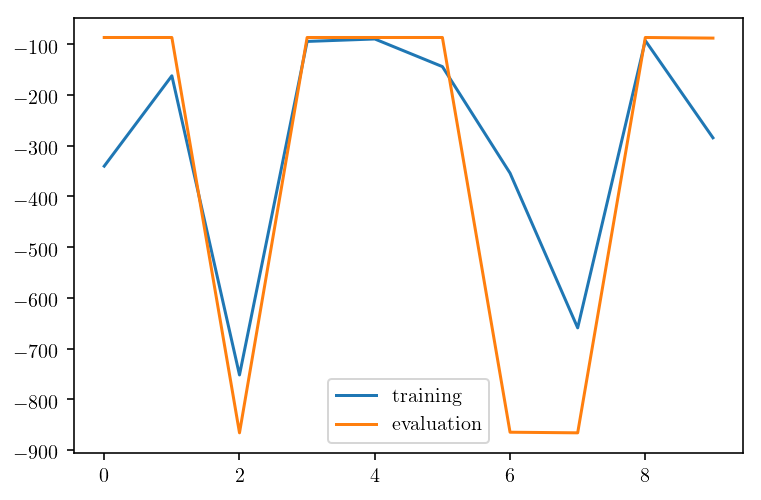

100%|###############################################################| 10/10 [10:41<00:00, 94.91s/it]


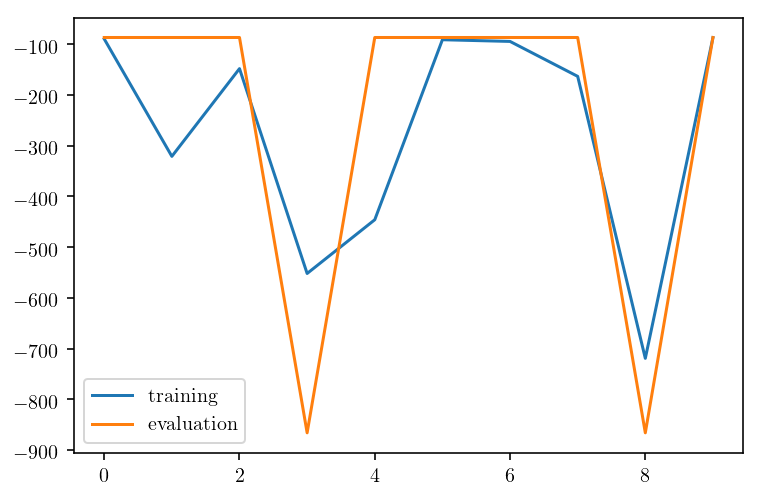

100%|##############################################################| 10/10 [21:17<00:00, 130.08s/it]


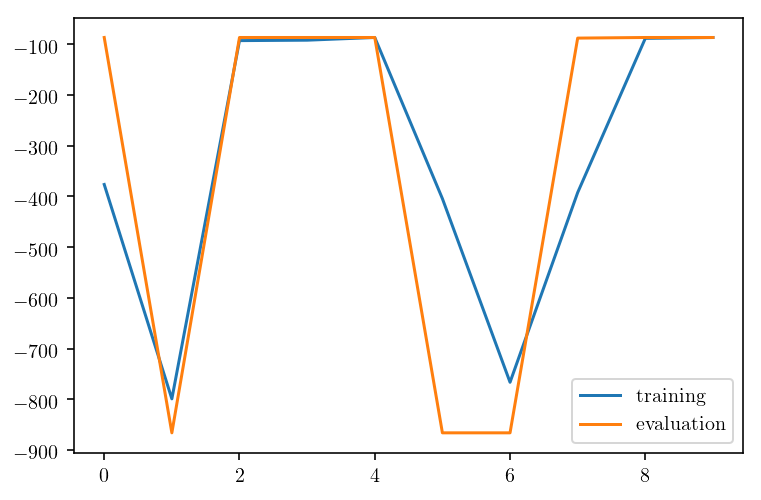

100%|###############################################################| 10/10 [14:58<00:00, 60.26s/it]


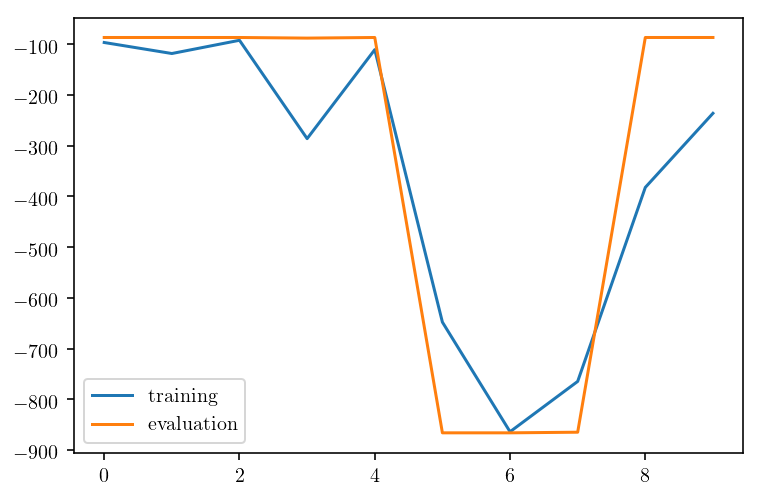

100%|##############################################################| 10/10 [15:00<00:00, 119.85s/it]


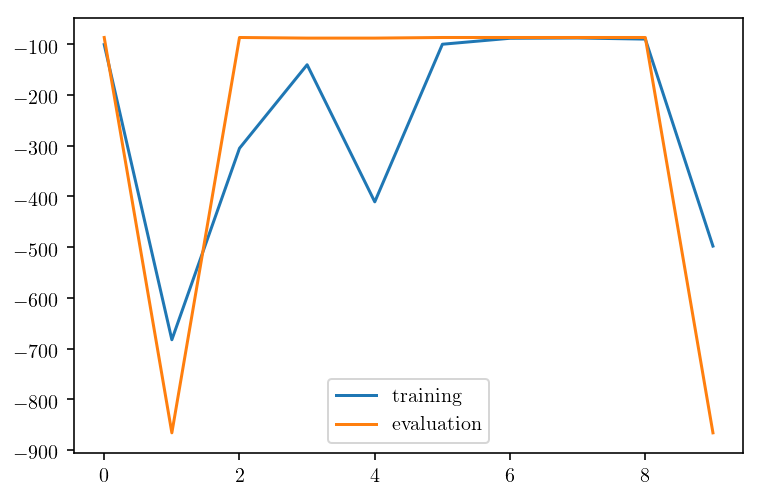

100%|##############################################################| 10/10 [22:33<00:00, 135.78s/it]


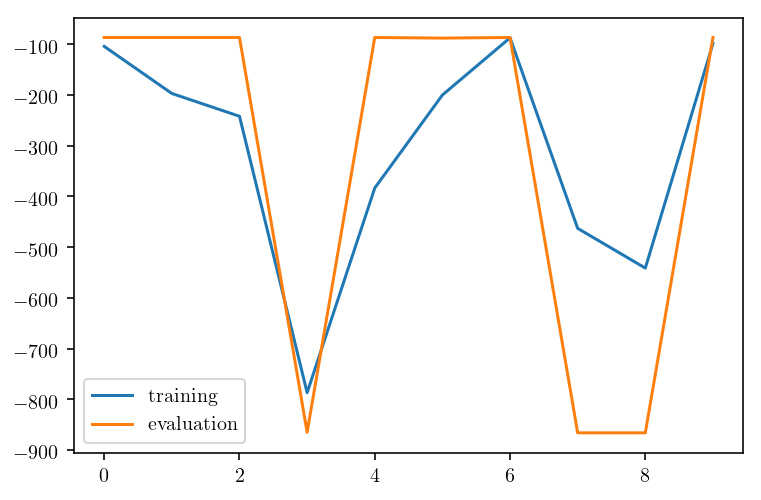

100%|##############################################################| 10/10 [22:31<00:00, 135.15s/it]


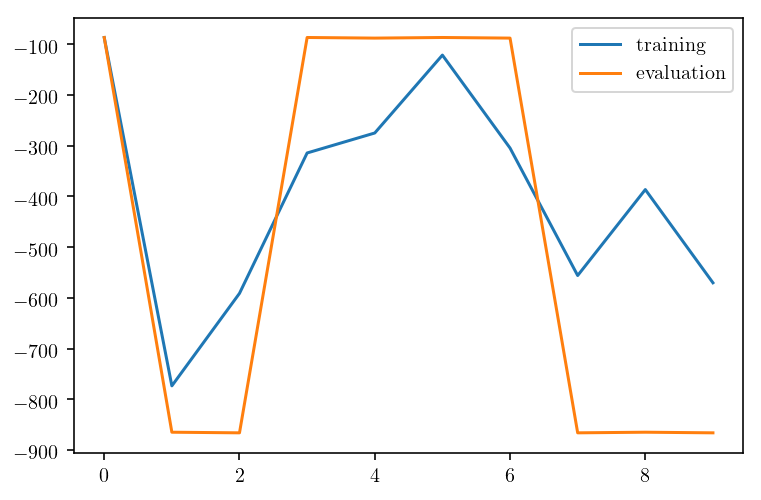

 30%|##################9                                            | 3/10 [06:46<15:48, 135.44s/it]

In [ ]:
agent.commit()
returns_train = []
returns_eval = []
q_estimation = []

for _ in range(10):
    
    returns = environment.train(segments=10, episodes=100)

    plt.figure()
    plt.plot(returns.T[0], label='training')
    plt.plot(returns.T[1], label='evaluation')
    plt.legend()
    plt.show()
    
    #agent.temperature *= .8
    
    returns_train.append(np.mean(returns.T[0]))
    returns_eval.append(np.mean(returns.T[1]))

    q_estimation.append(environment.agent.q(environment.state_representation(environment.environment.reset())))
    
    environment.agent.save('../saved/taxi/mlp')

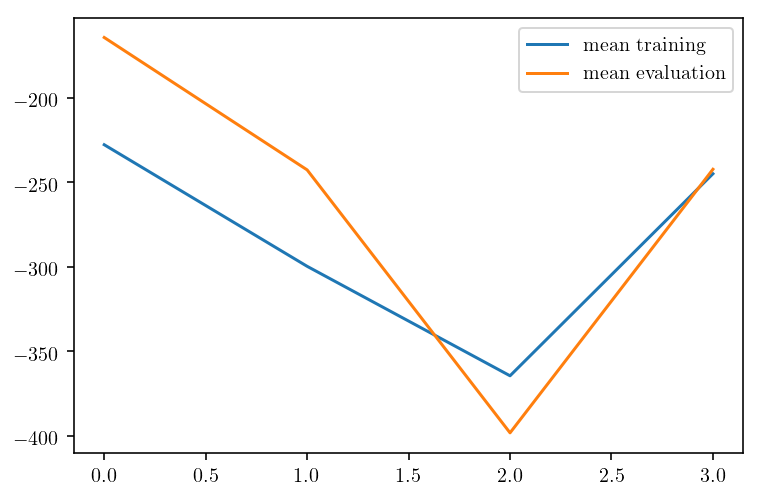

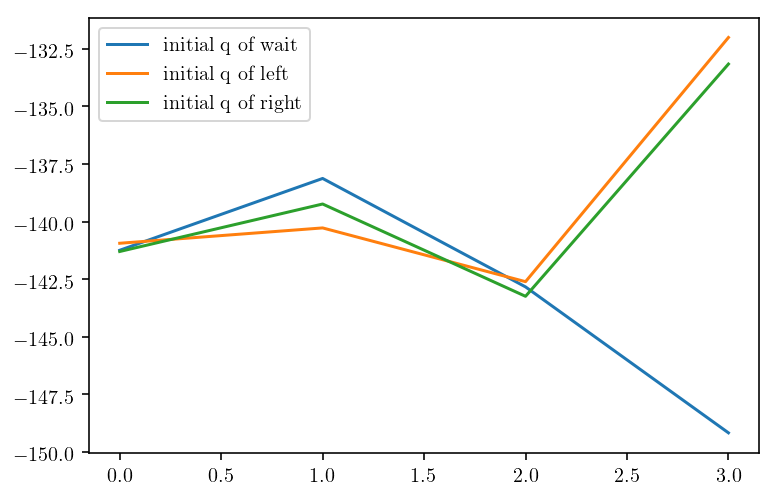

In [18]:
plt.figure()
plt.plot(returns_train, label='mean training')
plt.plot(returns_eval, label='mean evaluation')
plt.legend()
plt.show()

q_estimation = np.asarray(q_estimation)
plt.figure()
plt.plot(q_estimation[:, 0], label='initial q of wait')
plt.plot(q_estimation[:, 1], label='initial q of left')
plt.plot(q_estimation[:, 2], label='initial q of right')
plt.legend()
plt.show()

## Testing

In [19]:
for _ in range(1):
    environment.exploration_episode(render=True)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |


In [20]:
for _ in range(1):
    environment.evaluation_episode(render=True)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+--

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: 

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: 

## Save

In [41]:
environment.agent.save('../saved/mixed_mlp')